In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #61e4ae; position: static; color: #000000; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #186556; color: #ffffff; font-size: 40px; text-align: center;} .text_cell_render h3 { padding: 10px 12px; background-color: #61e4ae; position: static; color: #000000; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #186556; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #186556; border: solid; border-color: #ffffff; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# SYDNEY LIVEABILITY ANALYSIS

# Task 1: Building the Database

## Importing Modules and Loading Datasets

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import contextily as ctx
from sklearn import metrics

All the datasets are imported.

In [3]:
# Import supplied datasets
business_stats = pd.read_csv('BusinessStats.csv')
neighbourhood = pd.read_csv('Neighbourhoods.csv', index_col=False)
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")
catchment_future = gpd.read_file("school_catchments/catchments_future.shp")
catchment_primary = gpd.read_file("school_catchments/catchments_primary.shp")
catchment_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")
sa2_shape = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

In [4]:
# Import our own selected datasets
swimming_pool = gpd.read_file("Swimming_pools.geojson")
bicycle_parking = gpd.read_file("Bicycle_parking.geojson")

In [6]:
# As SRID of datasets are different, create SRID variables
break_and_enter_SRID = break_and_enter.crs.to_epsg()
sa2_shape_SRID = sa2_shape.crs.to_epsg()
school_catchment_SRID = catchment_secondary.crs.to_epsg()
swimming_pool_SRID = swimming_pool.crs.to_epsg()
bicycle_parking_SRID = bicycle_parking.crs.to_epsg()

## Data Wrangling

### Business stats:

Create a copy of the business stats.

In [7]:
# Create copy of dataset
business_stats_cp = business_stats.copy()

Check columns and attribute type are suitable:

In [8]:
business_stats_cp.dtypes

area_id                               int64
area_name                            object
number_of_businesses                  int64
accommodation_and_food_services       int64
retail_trade                          int64
agriculture_forestry_and_fishing      int64
health_care_and_social_assistance     int64
public_administration_and_safety      int64
transport_postal_and_warehousing      int64
dtype: object

Remove unnecessary infomation - only area id, area name, number_of_businesses, accommodation and food services,  retail services, health services are required

In [9]:
business_stats_cp = business_stats_cp.drop(columns=['agriculture_forestry_and_fishing', 'public_administration_and_safety','transport_postal_and_warehousing'])

Area name is an object, but it's more suitable if it is in the form of string so we are changing it to string datatype. 

In [10]:
business_stats_cp['area_name'] = business_stats_cp['area_name'].astype('string')

Checking if columns and datatype has changed

In [11]:
business_stats_cp.dtypes

area_id                               int64
area_name                            string
number_of_businesses                  int64
accommodation_and_food_services       int64
retail_trade                          int64
health_care_and_social_assistance     int64
dtype: object

This confirms that the selected columns have been droped and 'area_name' is of type *String* now

Checking duplicate rows:

In [12]:
business_stats_cp[business_stats_cp.duplicated()]

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,health_care_and_social_assistance


Checking that 'area_id' is unique, to see if we can make it the primary key

In [13]:
business_stats_cp[business_stats_cp['area_id'].duplicated()]

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,health_care_and_social_assistance


Check if data has any missing cells, if no missing cells then leave data as is

In [14]:
business_stats_cp[business_stats_cp.isna().any(axis=1)]

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,health_care_and_social_assistance


### Neighbourhoods

Creating a copy of the neighbourhood dataset.

In [15]:
# Create copy of dataset
neighbourhood_cp = neighbourhood.copy()

Checking data attribute types:

In [16]:
neighbourhood_cp.dtypes

Unnamed: 0                          int64
area_id                             int64
area_name                          object
land_area                         float64
population                         object
number_of_dwellings                object
number_of_businesses              float64
median_annual_household_income    float64
avg_monthly_rent                  float64
0-4                                 int64
5-9                                 int64
10-14                               int64
15-19                               int64
dtype: object

Remove old index columns from dataframe

In [17]:
neighbourhood_cp = neighbourhood_cp.drop(columns=['Unnamed: 0'])
neighbourhood_cp.columns

Index(['area_id', 'area_name', 'land_area', 'population',
       'number_of_dwellings', 'number_of_businesses',
       'median_annual_household_income', 'avg_monthly_rent', '0-4', '5-9',
       '10-14', '15-19'],
      dtype='object')

Check if data has any missing cells, if there are none then leave data as it is.

In [18]:
neighbourhood_cp[neighbourhood_cp.isna().any(axis=1)]

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
64,116031318,Prospect Reservoir,3069.2,40,5,500.0,53113.0,NaN,0,0,3,5
66,117011320,Banksmeadow,336.8,21,0,409.0,49680.0,NaN,2,0,0,0
70,117011324,Port Botany Industrial,280.4,7,0,135.0,NaN,NaN,0,0,0,0
71,117011325,Sydney Airport,891.1,202,0,9.0,NaN,NaN,10,4,1,7
88,118011342,Centennial Park,197.9,3,0,NaN,NaN,NaN,0,0,0,0
194,123021439,Holsworthy Military Area,12982.3,NaN,0,NaN,NaN,NaN,0,0,0,0
206,124011451,Blue Mountains - North,59503.7,13,6,3.0,NaN,NaN,0,0,2,0
211,124021456,Blue Mountains - South,245690.9,4,3,NaN,NaN,NaN,0,0,0,0
229,125011475,Rookwood Cemetery,301.5,3,0,3.0,NaN,NaN,0,0,0,0
246,125031486,Smithfield Industrial,430.2,35,0,684.0,57326.0,NaN,0,0,0,0


Filling missing cells with the 0s for their respective columns (for numerical attributes) but filling missing population as 1, to avoid zero division errors.

In [19]:
neighbourhood_cp['population'].fillna(1, inplace=True) 
neighbourhood_cp.fillna(0, inplace=True) 

Check all data is now filled 

In [20]:
neighbourhood_cp[neighbourhood_cp.isna().any(axis=1)]

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19


Area name, population, number of dwellings are objects and number of businesses is a float, they should be changed to more suitable types

In [21]:
neighbourhood_cp['area_name'] = neighbourhood_cp['area_name'].astype('string')

# some population has commas in it 
neighbourhood_cp['population'] = neighbourhood_cp['population'].astype('str')
neighbourhood_cp['population'] = neighbourhood_cp['population'].str.replace(',','')
neighbourhood_cp['population'] = neighbourhood_cp['population'].astype('int64')

# some number of dwellings has commas in it 
neighbourhood_cp['number_of_dwellings'] = neighbourhood_cp['number_of_dwellings'].astype('str')
neighbourhood_cp['number_of_dwellings'] = neighbourhood_cp['number_of_dwellings'].str.replace(',','')
neighbourhood_cp['number_of_dwellings'] = neighbourhood_cp['number_of_dwellings'].astype('int64')


neighbourhood_cp['number_of_businesses'] = neighbourhood_cp['number_of_businesses'].astype('int64')

Checking if the datatype has changed.

In [22]:
neighbourhood_cp.dtypes

area_id                             int64
area_name                          string
land_area                         float64
population                          int64
number_of_dwellings                 int64
number_of_businesses                int64
median_annual_household_income    float64
avg_monthly_rent                  float64
0-4                                 int64
5-9                                 int64
10-14                               int64
15-19                               int64
dtype: object

Checking duplicate rows:

In [23]:
neighbourhood_cp[neighbourhood_cp.duplicated()]

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19


Checking that 'area_id' is unique and it matches the 'area_id'column of business_stats so this will be the foreign key.

In [24]:
neighbourhood_cp[neighbourhood_cp['area_id'].duplicated()]

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19


### Break_and_enter

Create a copy of the dataset.

In [25]:
# Create copy of dataset
break_and_enter_cp = break_and_enter.copy()

Checking data attribute types:

In [26]:
break_and_enter_cp.dtypes

OBJECTID         int64
Contour        float64
Density         object
ORIG_FID         int64
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

Remove unnecessary infomation - Contour and ORIG_FID are not required

In [27]:
break_and_enter_cp = break_and_enter_cp.drop(columns=['Contour', 'ORIG_FID'])
break_and_enter_cp.columns

Index(['OBJECTID', 'Density', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype='object')

Check for missing values

In [28]:
break_and_enter_cp[break_and_enter_cp.isna().any(axis=1)]

,OBJECTID,Density,Shape_Leng,Shape_Area,geometry


Checking duplicate rows:

In [29]:
break_and_enter_cp[break_and_enter_cp.duplicated()]

,OBJECTID,Density,Shape_Leng,Shape_Area,geometry


Checking that 'OBJECTID' is unique, to see if we can make it the primary key:

In [30]:
break_and_enter_cp[break_and_enter_cp['OBJECTID'].duplicated()]

,OBJECTID,Density,Shape_Leng,Shape_Area,geometry


Change objects to suitable types

In [31]:
break_and_enter_cp["Density"] = break_and_enter_cp["Density"].astype('string')

Check if they were properly converted.

In [32]:
break_and_enter_cp.dtypes

OBJECTID         int64
Density         string
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

Check geom data is of the same type

In [33]:
break_and_enter_cp['geometry'].geom_type.unique()

array(['Polygon'], dtype=object)

All same type but we have to convert it to MultiPolygon to match other datasets, then convert to the Well-Known Text (WKT) format.

In [34]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [35]:
break_and_enter_cp['geom'] = break_and_enter_cp['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=break_and_enter_SRID))  # applying the function
break_and_enter_cp = break_and_enter_cp.drop(columns="geometry")  # deleting the old copy
break_and_enter_cp

,OBJECTID,Density,Shape_Leng,Shape_Area,geom
0,1,Low Density,0.012138,0.000006,MULTIPOLYGON (((149.9107801470001 -37.06636313...
1,2,Low Density,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,Low Density,0.006068,0.000002,MULTIPOLYGON (((148.9424993900001 -37.04208530...
3,4,Low Density,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,Low Density,0.008073,0.000003,MULTIPOLYGON (((149.8483600650001 -36.68458912...
...,...,...,...,...,...
2589,2590,High Density,0.015358,0.000011,MULTIPOLYGON (((153.2796105350001 -28.55387845...
2590,2591,High Density,0.028327,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,High Density,0.006654,0.000002,MULTIPOLYGON (((153.568248161 -28.383068159999...
2592,2593,High Density,0.047098,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


### Catchments_future

Creating a copy of the dataset.

In [36]:
# Create copy of dataset
catchment_future_cp = catchment_future.copy()

Checking data attribute types:

In [37]:
catchment_future_cp.dtypes

USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART       int64
YEAR1            int64
YEAR2            int64
YEAR3            int64
YEAR4            int64
YEAR5            int64
YEAR6            int64
YEAR7            int64
YEAR8            int64
YEAR9            int64
YEAR10           int64
YEAR11           int64
YEAR12           int64
geometry      geometry
dtype: object

Checking duplicate rows:

In [38]:
catchment_future_cp[catchment_future_cp.duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry


Checking that 'USE_ID' is unique, to see if we can make it the primary key:

In [39]:
catchment_future_cp[catchment_future_cp['USE_ID'].duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry


Check for missing values 

In [40]:
catchment_future_cp[catchment_future_cp.isna().any(axis=1)]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry


### Catchments_primary

Create a copy of the dataset.

In [41]:
# Create copy of dataset
catchment_primary_cp = catchment_primary.copy()

Checking data attribute types:

In [42]:
catchment_primary_cp.dtypes

USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object

Checking duplicate rows:

In [43]:
catchment_primary_cp[catchment_primary_cp.duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry


Checking that 'USE_ID' is unique, so this will be our primary key.

In [44]:
catchment_primary_cp[catchment_primary_cp['USE_ID'].duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry


Checking that 'CATCH_TYPE' for all schools is 'PRIMARY':

In [45]:
catchment_primary_cp[catchment_primary_cp['CATCH_TYPE'].duplicated()==False]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
8,5148,INFANTS,Bardwell Park IS,None,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,None,"POLYGON ((151.12810 -33.93058, 151.12831 -33.9..."
120,1055,CENTRAL_PRIMARY,Ariah Park CS,20200521,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.27572 -34.17436, 147.28320 -34.1..."


For the purpose of calculating the liveability scores, types 'INFANTS' and 'CENTRAL_PRIMARY' are acceptable, and do not need to be removed because we are considering young people, which has been defined as anyone aged 0-19. 

Check for missing values 

In [46]:
catchment_primary_cp[catchment_primary_cp.isna().any(axis=1)]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
1662,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
1663,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
1664,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


PRIORITY column is mostly None, check for non None values

In [47]:
[x for x in catchment_primary_cp['PRIORITY'] if x != None]

['N', 'N', 'N', 'N']

### Catchments_secondary

Create copy of dataset.

In [48]:
# Create copy of dataset
catchment_secondary_cp = catchment_secondary.copy()

Check the datatype.

In [49]:
catchment_secondary_cp.dtypes

USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object

Checking duplicate rows:

In [50]:
catchment_secondary_cp[catchment_secondary_cp.duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry


Checking that 'USE_ID' is unique, to see if we can make it the primary key:

In [51]:
catchment_secondary_cp[catchment_secondary_cp['USE_ID'].duplicated()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry


Checking that 'CATCH_TYPE' for all schools is a type of high school:

In [52]:
catchment_secondary_cp[catchment_secondary_cp['CATCH_TYPE'].duplicated()==False]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
10,2675,CENTRAL_HIGH,Mungindi CS,20200121,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((149.41114 -28.69428, 149.41377 -28.6..."
18,8241,HIGH_GIRLS,Moorefield GHS,None,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.16107 -33.93315, 151.16157 -33.9..."
35,8882,HIGH_BOYS,James Cook Boys Technology HS,None,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.16107 -33.93315, 151.16157 -33.9..."


Check for missing values.

In [53]:
catchment_secondary_cp[catchment_secondary_cp.isna().any(axis=1)]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8246,HIGH_COED,Heathcote HS,None,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.03281 -34.02521, 151.03267 -34.0..."
4,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
431,8857,HIGH_GIRLS,GRC Penshurst Girls,20220110,N,N,N,N,N,N,N,Y,Y,Y,Y,N,N,None,"POLYGON ((151.07573 -33.95089, 151.07921 -33.9..."
432,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
433,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


PRIORITY column is mostly None, check for non None values

In [54]:
[x for x in catchment_secondary_cp['PRIORITY'] if x != None]

['Y', 'N', 'N', 'N', 'N']

### School Catchment Data 

Remove unnecessary infomation - we only require - use_id, catch_type, use_desc and add_ date.

In [55]:
catchment_primary_cp = catchment_primary_cp.drop(columns=['CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'PRIORITY','KINDERGART','YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5','YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])
catchment_secondary_cp = catchment_secondary_cp.drop(columns=['CATCH_TYPE', 'USE_DESC', 'ADD_DATE','PRIORITY','KINDERGART','YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5','YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])
catchment_secondary_cp.columns

Index(['USE_ID', 'geometry'], dtype='object')

In [56]:
catchment_combined = pd.concat([catchment_primary_cp,catchment_secondary_cp])
catchment_combined

,USE_ID,geometry
0,2838,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...
430,8213,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
431,8857,"POLYGON ((151.07573 -33.95089, 151.07921 -33.9..."
432,3235,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
433,1115,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


Check for missing rows after deleted all unnecessary rows (including priority that was mostly Nones)

In [57]:
catchment_secondary_cp[catchment_secondary_cp.isna().any(axis=1)]

,USE_ID,geometry


In [58]:
repeated_ids = catchment_combined[catchment_combined['USE_ID'].duplicated()]
repeated_ids

,USE_ID,geometry
10,2675,"POLYGON ((149.41114 -28.69428, 149.41377 -28.6..."
50,8271,"POLYGON ((151.02575 -34.00570, 151.02581 -34.0..."
73,1921,"POLYGON ((159.06474 -31.50980, 159.06479 -31.5..."
79,1275,"POLYGON ((150.29611 -28.54032, 150.29668 -28.5..."
80,2897,"POLYGON ((150.01033 -33.04637, 150.00979 -33.0..."
...,...,...
426,3259,"POLYGON ((147.83834 -32.72012, 147.83450 -32.7..."
428,3555,"POLYGON ((148.59249 -32.44715, 148.58979 -32.4..."
432,3235,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
433,1115,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


In [59]:
# Combine geodata of schools with primary and secondary (using union)
for id in repeated_ids['USE_ID']:
    
    # Get primary and secondary row for school
    matching_ids_gpd = catchment_combined.loc[catchment_combined['USE_ID'].astype('int64')== int(id)]
#     print(matching_ids_gpd)
    
    if len(matching_ids_gpd.index.values) == 2:
        
        # Get union of primary and secondary polygones
        polygons_union = unary_union([matching_ids_gpd['geometry'].values[0], matching_ids_gpd['geometry'].values[1]])
        
         # Drop old rows
        catchment_combined = catchment_combined.drop([catchment_combined.index[matching_ids_gpd.index.values[0]], catchment_combined.index[matching_ids_gpd.index.values[1]]])
        
        # Add new row with union 
        row = [[id, polygons_union]]
        catchment_combined = catchment_combined.append(pd.DataFrame(row,
                       columns=[ 'USE_ID', 'geometry']), ignore_index = True)

In [60]:
catchment_combined[catchment_combined['USE_ID'].duplicated()]

,USE_ID,geometry


Check all geom data are of the same type.

In [61]:
catchment_combined['geometry'].geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

Convert all to MultiPolygon, then convert to the Well-Known Text (WKT) format.

In [62]:
catchment_combined['geom'] = catchment_combined['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=school_catchment_SRID))  # applying the function
catchment_combined = catchment_combined.drop(columns="geometry")  # deleting the old copy
catchment_combined

,USE_ID,geom
0,2838,MULTIPOLYGON (((150.93563850416 -33.7161211047...
1,3943,MULTIPOLYGON (((151.140850430121 -33.744626792...
2,2404,MULTIPOLYGON (((151.1833640465581 -33.74748398...
3,4393,MULTIPOLYGON (((151.0451821055135 -33.77303212...
4,4615,MULTIPOLYGON (((150.9256732797658 -33.72960300...
...,...,...
2032,3259,MULTIPOLYGON (((147.8383377947756 -32.72012196...
2033,3555,MULTIPOLYGON (((148.592487341035 -32.447147191...
2034,3235,MULTIPOLYGON (((143.3772340238832 -34.80172607...
2035,1115,MULTIPOLYGON (((143.6554085270323 -33.55702488...


Check the datatypes of the attributes. Since it's better to keep USE_ID as integer we convert it.

In [63]:
catchment_combined.dtypes

USE_ID    object
geom      object
dtype: object

Convert USE_ID to integer. 

In [64]:
catchment_combined['USE_ID'] = catchment_combined['USE_ID'].astype('int64')

Check if the type change is successful.

In [65]:
catchment_combined.dtypes

USE_ID     int64
geom      object
dtype: object

### SA2_Shape

Create copy of dataset.

In [66]:
# Create copy of dataset
sa2_shape_cp = sa2_shape.copy()

Checking data attribute types:

In [67]:
sa2_shape_cp.dtypes

SA2_MAIN16      object
SA2_5DIG16      object
SA2_NAME16      object
SA3_CODE16      object
SA3_NAME16      object
SA4_CODE16      object
SA4_NAME16      object
GCC_CODE16      object
GCC_NAME16      object
STE_CODE16      object
STE_NAME16      object
AREASQKM16     float64
geometry      geometry
dtype: object

As seen below, data is from all Australian states and territories. 

In [68]:
print(sa2_shape_cp['GCC_NAME16'].unique())

['Rest of NSW' 'Greater Sydney' 'Migratory - Offshore - Shipping (NSW)'
 'No usual address (NSW)' 'Rest of Vic.' 'Greater Melbourne'
 'Migratory - Offshore - Shipping (Vic.)' 'No usual address (Vic.)'
 'Greater Brisbane' 'Rest of Qld' 'Migratory - Offshore - Shipping (Qld)'
 'No usual address (Qld)' 'Greater Adelaide' 'Rest of SA'
 'Migratory - Offshore - Shipping (SA)' 'No usual address (SA)'
 'Rest of WA' 'Greater Perth' 'Migratory - Offshore - Shipping (WA)'
 'No usual address (WA)' 'Greater Hobart' 'Rest of Tas.'
 'Migratory - Offshore - Shipping (Tas.)' 'No usual address (Tas.)'
 'Greater Darwin' 'Rest of NT' 'Migratory - Offshore - Shipping (NT)'
 'No usual address (NT)' 'Australian Capital Territory'
 'Migratory - Offshore - Shipping (ACT)' 'No usual address (ACT)'
 'Other Territories' 'Migratory - Offshore - Shipping (OT)'
 'No usual address (OT)']


Hence, we should store necessary data only, ie data from NSW. 

In [69]:
sa2_shape_cp = sa2_shape_cp[sa2_shape_cp['GCC_NAME16']=='Greater Sydney']

In [70]:
print(sa2_shape_cp['GCC_NAME16'].unique())

['Greater Sydney']


Drop GCC and STE rows now that data is filtered for Greater Sydney

In [71]:
sa2_shape_cp = sa2_shape_cp.drop(columns=['GCC_CODE16','GCC_NAME16','STE_CODE16','STE_NAME16'])

Checking duplicate rows:

In [72]:
sa2_shape_cp[sa2_shape_cp.duplicated()]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geometry


Checking that 'SA2_MAIN16' is unique, and it matches with the area_id of business_stats, so this will be our foreign key.


In [73]:
sa2_shape_cp[sa2_shape_cp['SA2_MAIN16'].duplicated()]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geometry


Checking rows with 'None' values for 'geometry' attribute:

In [74]:
sa2_shape_cp[sa2_shape_cp['geometry']==None]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geometry


In [75]:
none_indexes = list(sa2_shape_cp[sa2_shape_cp['geometry']==None].index.values)
none_indexes # indexes of these rows

[]

The rows with 'None' values for the 'geometry' attribute are not relevant to the project, as they are not residential areas, hence the liveability scores need not be computed for them. Hence, these rows can be removed. 

In [76]:
sa2_shape_cp = sa2_shape_cp.drop(none_indexes)

In [77]:
sa2_shape_cp[sa2_shape_cp['geometry']==None]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geometry


Check for missing values

In [78]:
sa2_shape_cp[sa2_shape_cp.isna().any(axis=1)]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geometry


Ensuring all entries of 'geometry' column is of the same data type

In [79]:
sa2_shape_cp['geometry'].geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

Convert all to Multipolgyn then convert to the Well-Known Text (WKT) format

In [80]:
sa2_shape_cp['geom'] = sa2_shape_cp['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=sa2_shape_SRID))  # applying the function
sa2_shape_cp = sa2_shape_cp.drop(columns="geometry")  # deleting the old copy
sa2_shape_cp

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,AREASQKM16,geom
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...,...,...
571,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,139.3336,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,7.7547,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,8.9538,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,3.8436,MULTIPOLYGON (((151.0395427830001 -34.04175791...


Change object types to suitable types 

In [81]:
sa2_shape_cp['SA2_MAIN16'] = sa2_shape_cp['SA2_MAIN16'].astype('int64')
sa2_shape_cp['SA2_5DIG16'] = sa2_shape_cp['SA2_5DIG16'].astype('int64')
sa2_shape_cp['SA2_NAME16'] = sa2_shape_cp['SA2_NAME16'].astype('string')
sa2_shape_cp['SA3_CODE16'] = sa2_shape_cp['SA3_CODE16'].astype('int64')
sa2_shape_cp['SA3_NAME16'] = sa2_shape_cp['SA3_NAME16'].astype('string')
sa2_shape_cp['SA4_CODE16'] = sa2_shape_cp['SA4_CODE16'].astype('int64')
sa2_shape_cp['SA4_NAME16'] = sa2_shape_cp['SA4_NAME16'].astype('string')

Check type changes are successful

In [82]:
sa2_shape_cp.dtypes

SA2_MAIN16      int64
SA2_5DIG16      int64
SA2_NAME16     string
SA3_CODE16      int64
SA3_NAME16     string
SA4_CODE16      int64
SA4_NAME16     string
AREASQKM16    float64
geom           object
dtype: object

### Swimming Pools

Create a copy of the swimming pool dataset.

In [83]:
# Create copy of dataset
swimming_pool_cp = swimming_pool.copy()

Remove unnecessary columns - OBJECTID, Address2, Class, URL, PhoneNumber

In [84]:
swimming_pool_cp = swimming_pool_cp.drop(columns=['OBJECTID', 'Address2', 'URL', 'Class', 'PhoneNumber'])
swimming_pool_cp.columns

Index(['Name', 'Address', 'Suburb', 'Postcode', 'Details', 'geometry'], dtype='object')

In [85]:
swimming_pool_cp.dtypes

Name          object
Address       object
Suburb        object
Postcode       int64
Details       object
geometry    geometry
dtype: object

Changing the datatypes of the data so that Name, Address, Suburb, PhoneNumber and Details is String and Postcode is Integer

In [86]:
swimming_pool_cp['Name'] = swimming_pool_cp['Name'].astype('string')
swimming_pool_cp['Address'] = swimming_pool_cp['Address'].astype('string')
swimming_pool_cp['Suburb'] = swimming_pool_cp['Suburb'].astype('string')
swimming_pool_cp['Details'] = swimming_pool_cp['Details'].astype('string')
swimming_pool_cp['Postcode'] = swimming_pool_cp['Postcode'].astype('int64')
swimming_pool_cp['geometry'] = swimming_pool_cp['geometry'].astype('object')

Checking if the datatype changed

In [87]:
swimming_pool_cp.dtypes

Name        string
Address     string
Suburb      string
Postcode     int64
Details     string
geometry    object
dtype: object

In [88]:
swimming_pool_cp['geometry'].geom_type.unique()

array(['Point'], dtype=object)

Leave as Points but convert to the Well-Known Text (WKT) format

In [89]:
swimming_pool_cp['geom'] = swimming_pool_cp['geometry'].apply(lambda x: WKTElement(x.wkt, srid=swimming_pool_SRID))
swimming_pool_cp = swimming_pool_cp.drop(columns="geometry")  # deleting the old copy
swimming_pool_cp

,Name,Address,Suburb,Postcode,Details,geom
0,The Andrew (Boy) Charlton Pool,1C Mrs Macquaries Road,Sydney,2000,Outdoor Pool,POINT (151.222118310985 -33.8631781737978)
1,Cook+Phillip Park Aquatic & Fitness Centre,4 College Street,Sydney,2000,Indoor Pool,POINT (151.213082947101 -33.8729937245548)
2,Victoria Park Pool,1 City Road,Camperdown,2050,Outdoor Pool,POINT (151.192305578727 -33.8861315532426)
3,Prince Alfred Park Pool,105 Chalmers Street,Surry Hills,2010,Outdoor Pool,POINT (151.206026376099 -33.88750359056)
4,Ian Thorpe Aquatic Centre,458 Harris Street,Ultimo,2007,Indoor Pool,POINT (151.198901806217 -33.877302173433)


### Bicycle parking

Create a copy of the dataset.

In [90]:
# Create a copy of the dataset
bicycle_parking_cp = bicycle_parking.copy()
bicycle_parking_cp

,OBJECTID,AssetID,Type,StreetName,Suburb,Postcode,geometry
0,1453,BIKE15,Bike Maintenance Stand,Harbour Street,Sydney,2000,POINT (151.20243 -33.87431)
1,1454,00404691,Bike Maintenance Stand,Bourke Street,Surry Hills,2010,POINT (151.21611 -33.88325)
2,1455,00394233,Bike Maintenance Stand,Darling Drive,Sydney,2000,POINT (151.19822 -33.87024)
3,1456,00404840,Bike Maintenance Stand,Liverpool Street,Sydney,2000,POINT (151.21207 -33.87652)
4,1457,00405841,U-Rail,Argyle Place,Millers Point,2000,POINT (151.20303 -33.85838)
...,...,...,...,...,...,...,...
1558,3011,00404660,O-Ring,George Street,Sydney,2000,POINT (151.20665 -33.87460)
1559,3012,00406236,O-Ring,Kent Street,Millers Point,2000,POINT (151.20361 -33.85855)
1560,3013,00406237,O-Ring,Kent Street,Millers Point,2000,POINT (151.20362 -33.85868)
1561,3014,00394009,O-Ring,Harris Street,Pyrmont,2009,POINT (151.19411 -33.87015)


Check to see if OBJECTID is unique.

In [91]:
# Check to see if ObjectId is unique
bicycle_parking_cp[bicycle_parking_cp['OBJECTID'].duplicated()]

,OBJECTID,AssetID,Type,StreetName,Suburb,Postcode,geometry


Since it is, it will be our primary key. Next we check if any of the rows are duplicated.

In [92]:
# Check to see if there is any duplicate entries
bicycle_parking_cp[bicycle_parking_cp.duplicated()]

,OBJECTID,AssetID,Type,StreetName,Suburb,Postcode,geometry


Checking for any missing values. 

In [93]:
bicycle_parking_cp[bicycle_parking_cp.isna().any(axis=1)]

,OBJECTID,AssetID,Type,StreetName,Suburb,Postcode,geometry
244,1697,00394679,U-Rail,None,None,None,POINT (151.17902 -33.87862)
571,2024,BIKE05,O-Ring,None,None,None,POINT (151.20864 -33.85654)


In [94]:
bicycle_parking_cp.dropna(axis=0, how='any', inplace=True)
bicycle_parking_cp.shape

(1561, 7)

Checking the suburbs are a part of City of Sydney

In [95]:
bicycle_parking_cp['Suburb'].unique()

array(['Sydney', 'Surry Hills', 'Millers Point', 'Pyrmont', 'Haymarket',
       'Chippendale', 'Dawes Point', 'Ultimo', 'Rosebery', 'Beaconsfield',
       'Alexandria', 'Waterloo', 'Darlinghurst', 'Redfern', 'Camperdown',
       'Woolloomooloo', 'Zetland', 'Potts Point', 'Erskineville',
       'Forest Lodge', 'Newtown', 'The Rocks', 'Glebe', 'Darlington',
       'Rushcutters Bay', 'Paddington', 'Elizabeth Bay'], dtype=object)

Check if the datatypes are correct.

In [96]:
bicycle_parking_cp.dtypes

OBJECTID         int64
AssetID         object
Type            object
StreetName      object
Suburb          object
Postcode        object
geometry      geometry
dtype: object

In [97]:
bicycle_parking_cp['AssetID'] = bicycle_parking_cp['AssetID'].astype('string')
bicycle_parking_cp['Type'] = bicycle_parking_cp['Type'].astype('string')
bicycle_parking_cp['Suburb'] = bicycle_parking_cp['Suburb'].astype('string')
bicycle_parking_cp['StreetName'] = bicycle_parking_cp['StreetName'].astype('string')
bicycle_parking_cp['Postcode'] = bicycle_parking_cp['Postcode'].astype('int64')
bicycle_parking_cp['geometry'] = bicycle_parking_cp['geometry'].astype('object')

Check if the datatypes are have been converted successfully

In [98]:
bicycle_parking_cp.dtypes

OBJECTID       int64
AssetID       string
Type          string
StreetName    string
Suburb        string
Postcode       int64
geometry      object
dtype: object

Check the types of geometry data we have available

In [99]:
bicycle_parking_cp['geometry'].geom_type.unique()

array(['Point'], dtype=object)

As they are all of Point datatype no conversion is needed, but convert to the Well-Known Text (WKT) format.

In [100]:
bicycle_parking_cp['geom'] = bicycle_parking_cp['geometry'].apply(lambda x: WKTElement(x.wkt, srid=bicycle_parking_SRID))
bicycle_parking_cp = bicycle_parking_cp.drop(columns="geometry")  # deleting the old copy
bicycle_parking_cp

,OBJECTID,AssetID,Type,StreetName,Suburb,Postcode,geom
0,1453,BIKE15,Bike Maintenance Stand,Harbour Street,Sydney,2000,POINT (151.20243315 -33.87430960999995)
1,1454,00404691,Bike Maintenance Stand,Bourke Street,Surry Hills,2010,POINT (151.21610594 -33.88325101799995)
2,1455,00394233,Bike Maintenance Stand,Darling Drive,Sydney,2000,POINT (151.198217006 -33.87023500499998)
3,1456,00404840,Bike Maintenance Stand,Liverpool Street,Sydney,2000,POINT (151.212074988 -33.87651806199995)
4,1457,00405841,U-Rail,Argyle Place,Millers Point,2000,POINT (151.2030279830001 -33.85838098599993)
...,...,...,...,...,...,...,...
1558,3011,00404660,O-Ring,George Street,Sydney,2000,POINT (151.2066499910001 -33.87459803399997)
1559,3012,00406236,O-Ring,Kent Street,Millers Point,2000,POINT (151.2036139940001 -33.85855301599997)
1560,3013,00406237,O-Ring,Kent Street,Millers Point,2000,POINT (151.2036229610001 -33.85867704599997)
1561,3014,00394009,O-Ring,Harris Street,Pyrmont,2009,POINT (151.1941090720001 -33.87014600499998)


## Importing Data into Database

### Establishing database connection

To establish a database connection, we followed the week-4 tutorial.

In [101]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [102]:
db, conn = pgconnect(credentials)

Connected successfully.


### Table Definitions

We created tables for business_stats, neighbourhood, sa2_shape. As these 3 tables are connected by the AREA_ID of the business_stats table (PRIMARY and FOREIGN KEY) , we made sure we dropped them before creating a table for business_stats.

In [103]:
conn.execute("""
DROP TABLE IF EXISTS sa2_shape;
DROP TABLE IF EXISTS neighbourhood;
DROP TABLE IF EXISTS business_stats;
CREATE TABLE business_stats (
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(100), 
    number_of_businesses INTEGER,
    accommodation_and_food_services INTEGER,
    retail_trade INTEGER,
    health_care_and_social_assistance INTEGER
);"""
)
query(conn, "select * from business_stats")

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,health_care_and_social_assistance


In [104]:
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    area_id INTEGER, 
    area_name VARCHAR(100), 
    land_area FLOAT, 
    population INTEGER, 
    number_of_dwellings INTEGER,
    number_of_businesses INTEGER,
    median_annual_household_income FLOAT,
    avg_monthly_rent FLOAT,
    "0-4" INTEGER,
    "5-9" INTEGER,
    "10-14" INTEGER,
    "15-19" INTEGER,
    FOREIGN KEY(area_id) REFERENCES business_stats(area_id)
);"""
)
query(conn, "select * from neighbourhood")

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19


In [105]:
conn.execute("""
DROP TABLE IF EXISTS sa2_shape;
CREATE TABLE sa2_shape (
    SA2_MAIN16 INTEGER,
    SA2_5DIG16 INTEGER,
    SA2_NAME16 VARCHAR(100),
    SA3_CODE16 INTEGER,
    SA3_NAME16 VARCHAR(100),
    SA4_CODE16 INTEGER,
    SA4_NAME16 VARCHAR(100),
    AREASQKM16 FLOAT,
    geom GEOMETRY(MULTIPOLYGON, 4283),
    FOREIGN KEY(SA2_MAIN16) REFERENCES business_stats(area_id)
);"""
)
# Some Varchar can be smaller 
query(conn, "select * from sa2_shape;")

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,areasqkm16,geom


Creating a table for the break_and_enter data.

In [106]:
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter (
    objectid INTEGER PRIMARY KEY, 
    density VARCHAR(100),
    shape_leng FLOAT,
    shape_area FLOAT,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)
query(conn, "select * from break_and_enter")

,objectid,density,shape_leng,shape_area,geom


Creating a table for the schools. This is a combined table of the primary and secondary schools.

In [107]:
conn.execute("""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    use_id INTEGER PRIMARY KEY,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)
query(conn, "select * from schools")

,use_id,geom


Creating tables for the data we imported: swimming_pool and bicycle_parking.

In [108]:
conn.execute("""
DROP TABLE IF EXISTS swimming_pool;
CREATE TABLE swimming_pool (
    name VARCHAR(100) PRIMARY KEY, 
    address VARCHAR(100),
    suburb VARCHAR(100),
    postcode INTEGER, 
    details VARCHAR(100),
    geom GEOMETRY(POINT,4326)
);"""
)
query(conn, "select * from swimming_pool")

,name,address,suburb,postcode,details,geom


In [109]:
conn.execute("""
DROP TABLE IF EXISTS bicycle_parking;
CREATE TABLE bicycle_parking (
    objectid INTEGER PRIMARY KEY, 
    assetid VARCHAR(100),
    type VARCHAR(100),
    streetname VARCHAR(100),
    suburb VARCHAR(100),
    postcode INTEGER, 
    geom GEOMETRY(POINT,4326)
);"""
)
query(conn, "select * from  bicycle_parking")

,objectid,assetid,type,streetname,suburb,postcode,geom


### Table Population

Populate business stats, check if successful

In [110]:
business_stats_cp.to_sql("business_stats", con=conn, if_exists='append', index=False)
query(conn, "select * from business_stats limit 2")

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,health_care_and_social_assistance
0,101021007,Braidwood,629,26,27,11
1,101021008,Karabar,326,7,10,11


In [111]:
business_stats_cp.shape

(2301, 6)

In [112]:
query(conn, "select count(*) from business_stats")

,count
0,2301


Populate neighbourhood, check if successful

In [113]:
neighbourhood_cp.to_sql("neighbourhood", con=conn, if_exists='append', index=False)
query(conn, "select * from neighbourhood limit 2")

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738,46996.0,1906.0,467,583,604,560
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907,42621.0,1682.0,586,696,661,692


In [114]:
neighbourhood_cp.shape

(322, 12)

In [115]:
query(conn, "select count(*) from neighbourhood")

,count
0,322


Populate break and enter, check if successful 

In [116]:
# Match columns names with database 
break_and_enter_cp.columns = [x.lower() for x in break_and_enter_cp.columns]
break_and_enter_cp.columns

Index(['objectid', 'density', 'shape_leng', 'shape_area', 'geom'], dtype='object')

In [117]:
# Populate table 
break_and_enter_cp.to_sql("break_and_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', break_and_enter_SRID)})
query(conn, "select * from break_and_enter limit 2")

,objectid,density,shape_leng,shape_area,geom
0,1,Low Density,0.012138,0.000006,0106000020E61000000100000001030000000100000015...
1,2,Low Density,0.019106,0.000015,0106000020E6100000010000000103000000010000001D...


In [118]:
break_and_enter_cp.shape

(2594, 5)

In [119]:
query(conn, "select count(*) from break_and_enter")

,count
0,2594


Populate school, check if sucessful 

In [120]:
# Match columns names with database 
catchment_combined.columns = [x.lower() for x in catchment_combined.columns]
catchment_combined.columns

Index(['use_id', 'geom'], dtype='object')

In [121]:
# Populate table 
catchment_combined.to_sql("schools", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', school_catchment_SRID)})
query(conn, "select * from schools limit 2")

,use_id,geom
0,2838,0106000020BB1000000100000001030000000100000078...
1,3943,0106000020BB100000010000000103000000010000006F...


In [122]:
catchment_combined.shape

(2037, 2)

In [123]:
query(conn, "select count(*) from schools")

,count
0,2037


Populate sa2 shape, check if successful 

In [124]:
# Match columns names with database 
sa2_shape_cp.columns = [x.lower() for x in sa2_shape_cp.columns]
sa2_shape_cp.columns

Index(['sa2_main16', 'sa2_5dig16', 'sa2_name16', 'sa3_code16', 'sa3_name16',
       'sa4_code16', 'sa4_name16', 'areasqkm16', 'geom'],
      dtype='object')

In [125]:
# Populate table 
sa2_shape_cp.to_sql("sa2_shape", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', sa2_shape_SRID)})
query(conn, "select * from sa2_shape limit 2")

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,areasqkm16,geom
0,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020BB100000010000000103000000010000005E...
1,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0860,0106000020BB1000000100000001030000000100000000...


In [126]:
sa2_shape_cp.shape

(312, 9)

In [127]:
query(conn, "select count(*) from sa2_shape")

,count
0,312


Populate swimming pool, check if successful

In [128]:
# Match columns names with database 
swimming_pool_cp.columns = [x.lower() for x in swimming_pool_cp.columns]
swimming_pool_cp.columns

Index(['name', 'address', 'suburb', 'postcode', 'details', 'geom'], dtype='object')

In [129]:
# Populate table
swimming_pool_cp.to_sql("swimming_pool", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', swimming_pool_SRID)})
query(conn, "select * from swimming_pool limit 2")

,name,address,suburb,postcode,details,geom
0,The Andrew (Boy) Charlton Pool,1C Mrs Macquaries Road,Sydney,2000,Outdoor Pool,0101000020E6100000BF30DC971BE76240918A559F7CEE...
1,Cook+Phillip Park Aquatic & Fitness Centre,4 College Street,Sydney,2000,Indoor Pool,0101000020E61000004A245493D1E66240BE492442BEEF...


In [130]:
swimming_pool_cp.shape

(5, 6)

In [131]:
query(conn, "select count(*) from swimming_pool")

,count
0,5


Populate bicycle parking, check if successful

In [132]:
# Match columns names with database 
bicycle_parking_cp.columns = [x.lower() for x in bicycle_parking_cp.columns]
bicycle_parking_cp.columns

Index(['objectid', 'assetid', 'type', 'streetname', 'suburb', 'postcode',
       'geom'],
      dtype='object')

In [133]:
# Populate table 
bicycle_parking_cp.to_sql("bicycle_parking", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', bicycle_parking_SRID)})
query(conn, "select * from bicycle_parking limit 2")

,objectid,assetid,type,streetname,suburb,postcode,geom
0,1453,BIKE15,Bike Maintenance Stand,Harbour Street,Sydney,2000,0101000020E61000000ADC15557AE662409FC39660E9EF...
1,1454,00404691,Bike Maintenance Stand,Bourke Street,Surry Hills,2010,0101000020E6100000AF180157EAE66240F83B8E5E0EF1...


In [134]:
bicycle_parking_cp.shape

(1561, 7)

In [135]:
query(conn, "select count(*) from bicycle_parking")

,count
0,1561


# Task 2: Greater Sydney Liveability Analysis

## Compute Liveability Score

### Create Indexes

We have created 3 indexes for task-2. They are on the geom data of the following tables: sa2_shape, break_and_enter and schools. Since we had to form spatial joins, increating indexes on these tables will speed up the process.

In [136]:
conn.execute("""
DROP INDEX IF EXISTS sa2_shape_idx;
CREATE INDEX sa2_shape_idx ON sa2_shape USING GIST (geom);
""")

In [137]:
conn.execute("""
DROP INDEX IF EXISTS break_and_enter_idx;
CREATE INDEX break_and_enter_idx ON break_and_enter USING GIST (geom);
""")

In [138]:
conn.execute("""
DROP INDEX IF EXISTS schools_idx;
CREATE INDEX schools_idx ON schools USING GIST (geom);
""")

### Querying Data

In [139]:
business_stats_per_1000 = query(conn,
"""
SELECT B.area_id, 
    B.area_name,
    N.avg_monthly_rent,
    N.median_annual_household_income,
    N.population, 
    (CAST(B.accommodation_and_food_services as FLOAT)/CAST(N.population as FLOAT))*1000 as "Accom_per_pop",
    (CAST(B.retail_trade as FLOAT)/CAST(N.population as FLOAT))*1000 as "Retail_per_pop",
    (CAST(B.health_care_and_social_assistance as FLOAT)/CAST(N.population as FLOAT))*1000 as "Health_per_pop"
FROM sa2_shape S INNER JOIN neighbourhood N ON (S.SA2_MAIN16 = N.area_id)
                    INNER JOIN business_stats B ON (B.area_id = N.area_id)
WHERE N.population > 0
ORDER BY B.area_id
""")
business_stats_per_1000

,area_id,area_name,avg_monthly_rent,median_annual_household_income,population,Accom_per_pop,Retail_per_pop,Health_per_pop
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,7590,4.347826,4.611331,7.905138
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,10986,2.093574,4.096122,3.914072
2,102011030,Calga - Kulnura,1182.0,42105.0,4841,2.891964,8.882462,2.478827
3,102011031,Erina - Green Point,1595.0,43481.0,14237,4.776287,10.184730,12.572873
4,102011032,Gosford - Springfield,1382.0,45972.0,19385,4.849110,8.614908,12.690224
...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,28,107.142857,0.000000,0.000000
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,21760,3.354779,5.193015,5.836397
309,128021607,Engadine,1955.0,52667.0,17424,2.123508,3.960055,4.706152
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,7426,1.211958,2.693240,3.366550


In [140]:
crime = query(conn, 
"""
SELECT SH.sa2_main16,  SH.areasqkm16, T.count
FROM sa2_shape SH
JOIN (SELECT S.sa2_main16, count(B.objectid) as "count"
        FROM sa2_shape S
        LEFT OUTER JOIN break_and_enter B on ST_Intersects(ST_Transform(S.geom, 4326), B.geom)
        GROUP BY s.sa2_main16 
        ORDER BY s.sa2_main16) T
        ON (SH.sa2_main16 = T.sa2_main16)
ORDER BY SH.sa2_main16   
""")
crime['hotspot_density'] = crime['count']/crime['areasqkm16']
crime

,sa2_main16,areasqkm16,count,hotspot_density
0,102011028,6.4376,0,0.000000
1,102011029,32.0860,4,0.124665
2,102011030,767.9512,0,0.000000
3,102011031,33.7934,5,0.147958
4,102011032,16.9124,7,0.413897
...,...,...,...,...
307,128021537,139.3336,0,0.000000
308,128021538,7.7547,5,0.644770
309,128021607,8.9538,3,0.335053
310,128021608,3.8436,0,0.000000


In [141]:
schools_per_young_1000 = query(conn,
"""
SELECT N.area_id, N.area_name, T.num_schools, 
        (N."0-4" + N."5-9" + N."10-14" + N."15-19") as "young_population",
        (CAST(T.num_schools as FLOAT)/CAST(N.population as FLOAT))*1000 as "catchments_per_1000"
FROM neighbourhood N JOIN 
        (SELECT SH.SA2_MAIN16, count(S.use_id) as "num_schools"
        FROM sa2_shape SH LEFT OUTER JOIN schools S ON ST_Intersects(ST_Transform(SH.geom, 4326), ST_Transform(S.geom, 4326))
        GROUP BY SH.SA2_MAIN16) T
        ON (T.SA2_MAIN16 = N.area_id)
ORDER BY N.area_id
""")
schools_per_young_1000

,area_id,area_name,num_schools,young_population,catchments_per_1000
0,102011028,Avoca Beach - Copacabana,6,2214,0.790514
1,102011029,Box Head - MacMasters Beach,8,2635,0.728200
2,102011030,Calga - Kulnura,27,1098,5.577360
3,102011031,Erina - Green Point,17,3227,1.194072
4,102011032,Gosford - Springfield,14,4219,0.722208
...,...,...,...,...,...
307,128021537,Royal National Park,17,8,607.142857
308,128021538,Sutherland - Kirrawee,15,4894,0.689338
309,128021607,Engadine,10,5176,0.573921
310,128021608,Loftus - Yarrawarrah,6,2054,0.807972


### Calculating mean and standard deviations

In [142]:
retail_std = np.nanstd(np.array(business_stats_per_1000['Retail_per_pop']))
retail_mean = np.mean(business_stats_per_1000['Retail_per_pop'])
health_std = np.nanstd(np.array(business_stats_per_1000['Health_per_pop']))
health_mean = np.mean(business_stats_per_1000['Health_per_pop'])
accom_std = np.nanstd(np.array(business_stats_per_1000['Accom_per_pop']))
accom_mean = np.mean(business_stats_per_1000['Accom_per_pop'])
crime_std = np.nanstd(np.array(crime['hotspot_density']))
crime_mean = np.mean(crime['hotspot_density'])
schools_std = np.nanstd(np.array(schools_per_young_1000['catchments_per_1000']))
schools_mean = np.mean(schools_per_young_1000['catchments_per_1000'])

### Calculating z-scores

In [143]:
z_scores = business_stats_per_1000.copy()

In [144]:
z_scores['retail_z'] = (z_scores['Retail_per_pop']-retail_mean)/retail_std
z_scores['health_z'] = (z_scores['Health_per_pop']-health_mean)/health_std
z_scores['accom_z'] = (z_scores['Accom_per_pop']-accom_mean)/accom_std

In [145]:
z_scores = z_scores[['area_id','area_name','avg_monthly_rent','median_annual_household_income','retail_z','health_z','accom_z']]
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,retail_z,health_z,accom_z
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,-0.145935,0.059750,-0.122017
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,-0.149010,-0.183925,-0.163841
2,102011030,Calga - Kulnura,1182.0,42105.0,-0.120437,-0.271554,-0.149028
3,102011031,Erina - Green Point,1595.0,43481.0,-0.112663,0.344738,-0.114068
4,102011032,Gosford - Springfield,1382.0,45972.0,-0.122035,0.351903,-0.112717
...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,-0.173463,-0.422899,1.785180
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,-0.142462,-0.066557,-0.140442
309,128021607,Engadine,1955.0,52667.0,-0.149823,-0.135565,-0.163286
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,-0.157385,-0.217354,-0.180198


In [146]:
crime['crime_z'] = (crime['hotspot_density']-crime_mean)/crime_std
crime = crime[['sa2_main16','crime_z']]
crime

,sa2_main16,crime_z
0,102011028,-1.218419
1,102011029,-1.075299
2,102011030,-1.218419
3,102011031,-1.048558
4,102011032,-0.743251
...,...,...
307,128021537,-1.218419
308,128021538,-0.478201
309,128021607,-0.833766
310,128021608,-1.218419


In [147]:
z_scores['schools_z'] = (schools_per_young_1000['catchments_per_1000']-schools_mean)/schools_std

In [148]:
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,retail_z,health_z,accom_z,schools_z
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,-0.145935,0.059750,-0.122017,-0.111491
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,-0.149010,-0.183925,-0.163841,-0.111564
2,102011030,Calga - Kulnura,1182.0,42105.0,-0.120437,-0.271554,-0.149028,-0.105932
3,102011031,Erina - Green Point,1595.0,43481.0,-0.112663,0.344738,-0.114068,-0.111023
4,102011032,Gosford - Springfield,1382.0,45972.0,-0.122035,0.351903,-0.112717,-0.111571
...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,-0.173463,-0.422899,1.785180,0.592783
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,-0.142462,-0.066557,-0.140442,-0.111609
309,128021607,Engadine,1955.0,52667.0,-0.149823,-0.135565,-0.163286,-0.111743
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,-0.157385,-0.217354,-0.180198,-0.111471


Combining tables for ease when calculating liveability scores:

The tables 'z_scores', 'schools_per_young_1000' and 'crime' each have 312 rows, which were ordered by the SA2 area codes in the query, hence we can join columns as follows. 

In [149]:
z_scores['crime_z'] = crime['crime_z']

In [150]:
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,retail_z,health_z,accom_z,schools_z,crime_z
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,-0.145935,0.059750,-0.122017,-0.111491,-1.218419
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,-0.149010,-0.183925,-0.163841,-0.111564,-1.075299
2,102011030,Calga - Kulnura,1182.0,42105.0,-0.120437,-0.271554,-0.149028,-0.105932,-1.218419
3,102011031,Erina - Green Point,1595.0,43481.0,-0.112663,0.344738,-0.114068,-0.111023,-1.048558
4,102011032,Gosford - Springfield,1382.0,45972.0,-0.122035,0.351903,-0.112717,-0.111571,-0.743251
...,...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,-0.173463,-0.422899,1.785180,0.592783,-1.218419
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,-0.142462,-0.066557,-0.140442,-0.111609,-0.478201
309,128021607,Engadine,1955.0,52667.0,-0.149823,-0.135565,-0.163286,-0.111743,-0.833766
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,-0.157385,-0.217354,-0.180198,-0.111471,-1.218419


### Calculating scores

Calculating sum before applying sigmoid function:

In [151]:
z_scores['sum'] = z_scores['schools_z']+z_scores['accom_z']+z_scores['retail_z']-z_scores['crime_z']+z_scores['health_z']

In [152]:
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,retail_z,health_z,accom_z,schools_z,crime_z,sum
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,-0.145935,0.059750,-0.122017,-0.111491,-1.218419,0.898725
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,-0.149010,-0.183925,-0.163841,-0.111564,-1.075299,0.466959
2,102011030,Calga - Kulnura,1182.0,42105.0,-0.120437,-0.271554,-0.149028,-0.105932,-1.218419,0.571468
3,102011031,Erina - Green Point,1595.0,43481.0,-0.112663,0.344738,-0.114068,-0.111023,-1.048558,1.055543
4,102011032,Gosford - Springfield,1382.0,45972.0,-0.122035,0.351903,-0.112717,-0.111571,-0.743251,0.748831
...,...,...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,-0.173463,-0.422899,1.785180,0.592783,-1.218419,3.000020
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,-0.142462,-0.066557,-0.140442,-0.111609,-0.478201,0.017130
309,128021607,Engadine,1955.0,52667.0,-0.149823,-0.135565,-0.163286,-0.111743,-0.833766,0.273350
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,-0.157385,-0.217354,-0.180198,-0.111471,-1.218419,0.552011


Input values into the sigmoid function:

In [153]:
z_scores['score'] = 1/(1+np.exp(-z_scores['sum']))
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,retail_z,health_z,accom_z,schools_z,crime_z,sum,score
0,102011028,Avoca Beach - Copacabana,1906.0,46996.0,-0.145935,0.059750,-0.122017,-0.111491,-1.218419,0.898725,0.710687
1,102011029,Box Head - MacMasters Beach,1682.0,42621.0,-0.149010,-0.183925,-0.163841,-0.111564,-1.075299,0.466959,0.614664
2,102011030,Calga - Kulnura,1182.0,42105.0,-0.120437,-0.271554,-0.149028,-0.105932,-1.218419,0.571468,0.639102
3,102011031,Erina - Green Point,1595.0,43481.0,-0.112663,0.344738,-0.114068,-0.111023,-1.048558,1.055543,0.741838
4,102011032,Gosford - Springfield,1382.0,45972.0,-0.122035,0.351903,-0.112717,-0.111571,-0.743251,0.748831,0.678924
...,...,...,...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,1899.0,0.0,-0.173463,-0.422899,1.785180,0.592783,-1.218419,3.000020,0.952575
308,128021538,Sutherland - Kirrawee,1809.0,53378.0,-0.142462,-0.066557,-0.140442,-0.111609,-0.478201,0.017130,0.504283
309,128021607,Engadine,1955.0,52667.0,-0.149823,-0.135565,-0.163286,-0.111743,-0.833766,0.273350,0.567915
310,128021608,Loftus - Yarrawarrah,2163.0,51243.0,-0.157385,-0.217354,-0.180198,-0.111471,-1.218419,0.552011,0.634602


## Visualise Scores

### Overall Score by Table

In [154]:
z_scores[['area_id','area_name','score']]

,area_id,area_name,score
0,102011028,Avoca Beach - Copacabana,0.710687
1,102011029,Box Head - MacMasters Beach,0.614664
2,102011030,Calga - Kulnura,0.639102
3,102011031,Erina - Green Point,0.741838
4,102011032,Gosford - Springfield,0.678924
...,...,...,...
307,128021537,Royal National Park,0.952575
308,128021538,Sutherland - Kirrawee,0.504283
309,128021607,Engadine,0.567915
310,128021608,Loftus - Yarrawarrah,0.634602


### Overall Score

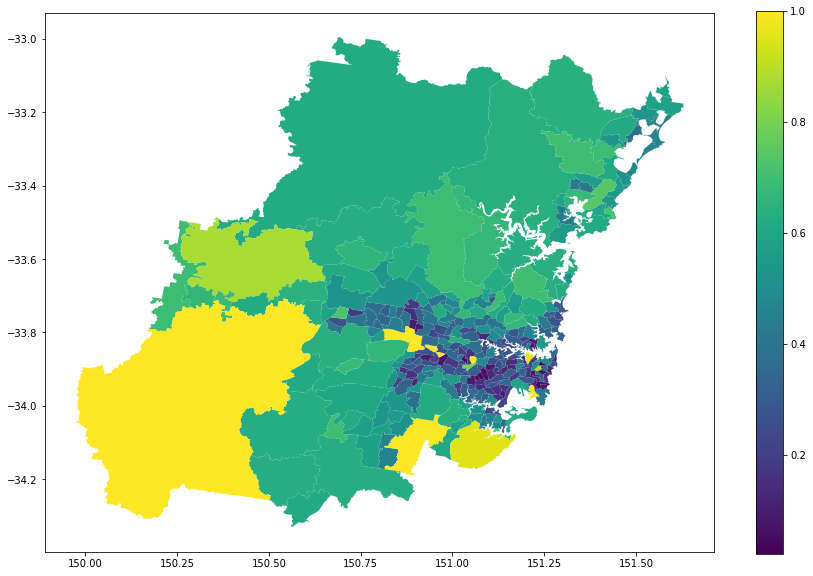

In [155]:
score_vis = gpd.read_postgis(
"""
SELECT SH.SA2_MAIN16, ST_Transform(SH.geom, 4326) as "geom"
FROM sa2_shape SH
ORDER BY SH.SA2_MAIN16 
"""
, conn)
score_vis['score'] = z_scores['score']
score_vis.plot(column='score', legend=True, figsize=(15, 10))

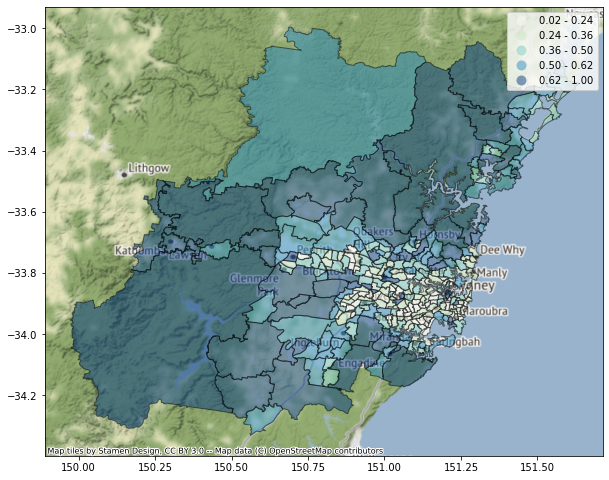

In [156]:
score_vis = score_vis.to_crs(epsg=4326)
ax = score_vis.plot(column='score',figsize=(10, 10), alpha=0.5, edgecolor='k' ,cmap='GnBu',legend=True,scheme="quantiles")#Add background tiles to plot
ctx.add_basemap(ax, crs=score_vis.crs.to_string())

### Breakdown of scores

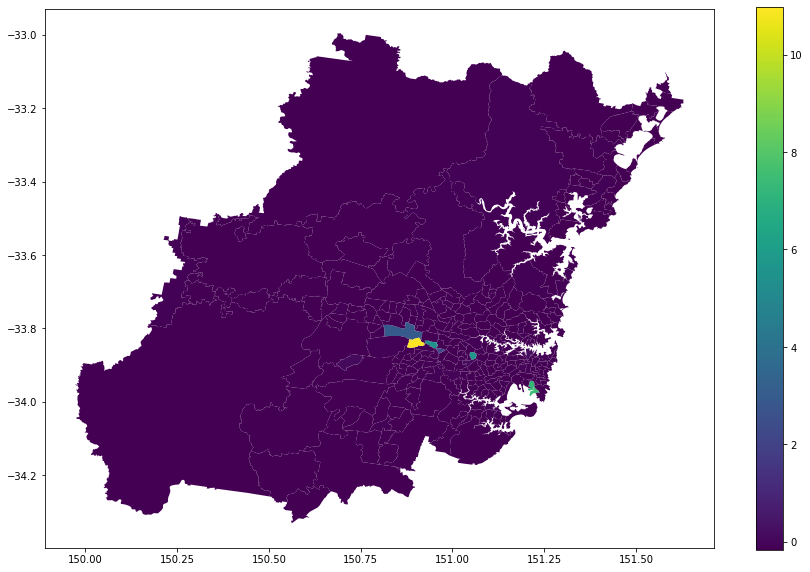

In [157]:
score_vis['retail_z'] = z_scores['retail_z']
score_vis.plot(column='retail_z', legend=True, figsize=(15, 10))

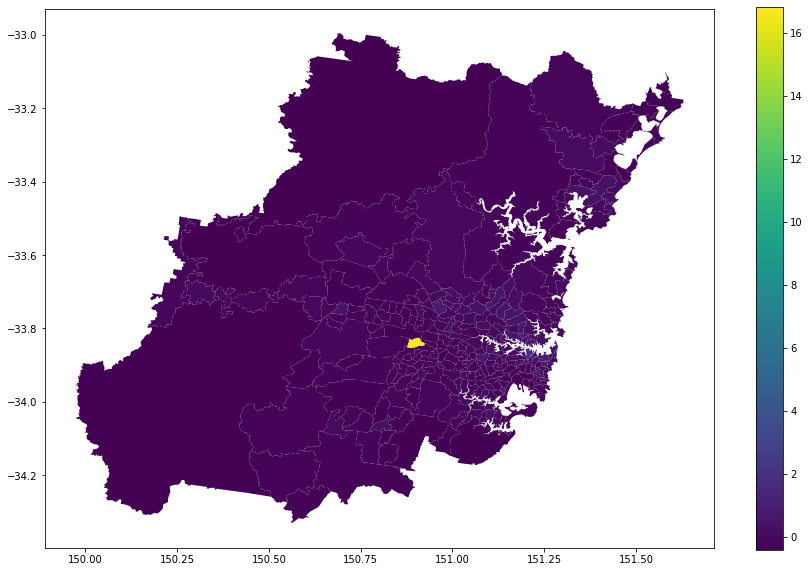

In [158]:
score_vis['health_z'] = z_scores['health_z']
score_vis.plot(column='health_z', legend=True, figsize=(15, 10))

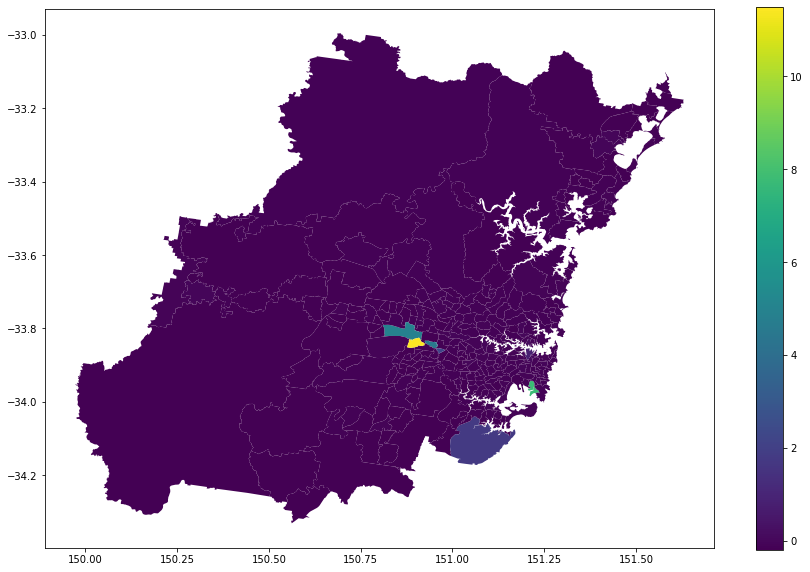

In [159]:
score_vis['accom_z'] = z_scores['accom_z']
score_vis.plot(column='accom_z', legend=True, figsize=(15, 10))

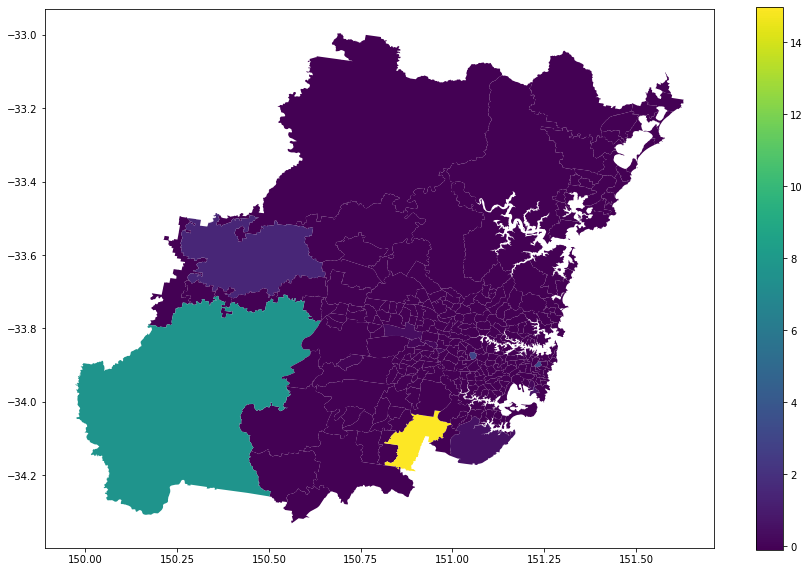

In [160]:
score_vis['schools_z'] = z_scores['schools_z']
score_vis.plot(column='schools_z', legend=True, figsize=(15, 10))

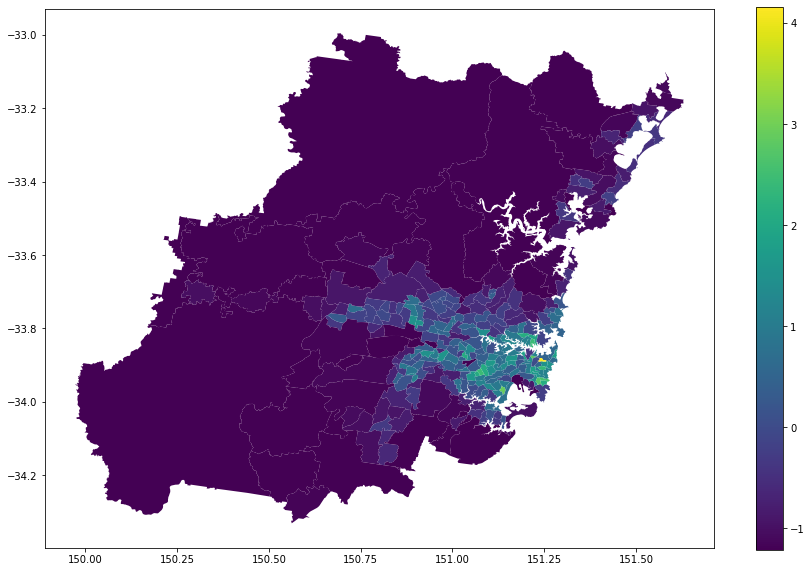

In [161]:
score_vis['crime_z'] = z_scores['crime_z']
score_vis.plot(column='crime_z', legend=True, figsize=(15, 10))

## Data and Score Correlations 

Defining data

In [162]:
scores = z_scores['score']
rent = z_scores['avg_monthly_rent']
income = z_scores['median_annual_household_income']

Finding line of best fit (coefficients)

In [163]:
a1, b1 = np.polyfit(scores, rent,1)
a2, b2 = np.polyfit(scores, income,1)

##### Mean Monthly Rent

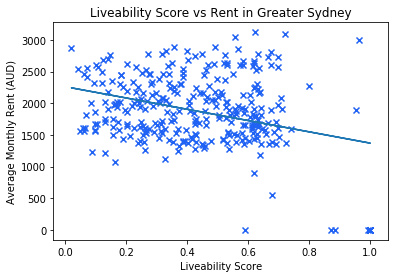

In [164]:
plt.scatter(scores, rent, color='#2062F3', marker='x', label='rent')
plt.plot(scores, a1*scores+b1)
plt.title('Liveability Score vs Rent in Greater Sydney')
plt.xlabel('Liveability Score')
plt.ylabel('Average Monthly Rent (AUD)') 
plt.show()

Computing the R^2 value for this data:

In [165]:
rent_r2 = metrics.r2_score(rent, a1*scores+b1)
rent_r2

0.1051727189010192

Correlation coefficient:


In [166]:
r_rent = np.sqrt(rent_r2)
r_rent

0.32430343646193327

Gradient of line of best fit:

In [167]:
a1

-892.1228699814262

##### Median Income

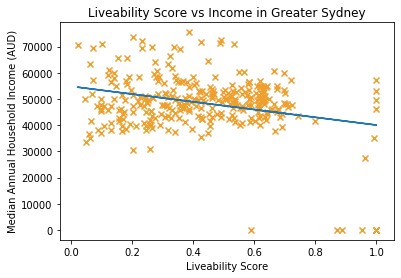

In [168]:
plt.scatter(scores, income, color='#eda02d', marker='x', label='rent')
plt.plot(scores, a2*scores+b2)
plt.title('Liveability Score vs Income in Greater Sydney')
plt.xlabel('Liveability Score')
plt.ylabel('Median Annual Household Income (AUD)') 
plt.show()

In [169]:
income_r2 = metrics.r2_score(income, a2*scores+b2)
income_r2

0.08141674624674566

Correlation coefficient:


In [170]:
r_income = np.sqrt(income_r2)
r_income

0.28533619862671766

Gradient of line of best fit:


In [171]:
a2

-14780.307361262721

# Task 3: City of Sydney Analysis

## Compute New Liveability Score

### Create Indexes

We created additional indexes on the geom of swimming_pool and bicycle_parking to speed up the query for task-3.

In [172]:
conn.execute("""
DROP INDEX IF EXISTS swimming_pool_idx;
CREATE INDEX swimming_pool_idx ON swimming_pool USING GIST (geom);
""")

In [173]:
conn.execute("""
DROP INDEX IF EXISTS bicycle_parking_idx;
CREATE INDEX bicycle_parking_idx ON bicycle_parking USING GIST (geom);
""")

### Querying Data

**Re Querying Previous Data for only City of Sydney**

In [174]:
business_stats_per_1000 = query(conn,
"""
SELECT B.area_id, 
    B.area_name,
    N.avg_monthly_rent,
    N.median_annual_household_income,
    N.population, 
    (CAST(B.accommodation_and_food_services as FLOAT)/CAST(N.population as FLOAT))*1000 as "Accom_per_pop",
    (CAST(B.retail_trade as FLOAT)/CAST(N.population as FLOAT))*1000 as "Retail_per_pop",
    (CAST(B.health_care_and_social_assistance as FLOAT)/CAST(N.population as FLOAT))*1000 as "Health_per_pop"
FROM sa2_shape S INNER JOIN neighbourhood N ON (S.SA2_MAIN16 = N.area_id)
                    INNER JOIN business_stats B ON (B.area_id = N.area_id)
WHERE N.population > 0 and S.sa3_name16 = 'Sydney Inner City'
ORDER BY B.area_id
""")
business_stats_per_1000

,area_id,area_name,avg_monthly_rent,median_annual_household_income,population,Accom_per_pop,Retail_per_pop,Health_per_pop
0,117031329,Darlinghurst,2491.0,59293.0,12414,15.708072,12.083132,22.555180
1,117031330,Erskineville - Alexandria,2581.0,69680.0,17822,7.799349,14.644821,6.284368
2,117031331,Glebe - Forest Lodge,2162.0,56691.0,21592,5.603927,5.372360,8.382734
3,117031332,Newtown - Camperdown - Darlington,2270.0,58210.0,27450,7.322404,5.974499,13.114754
4,117031333,Potts Point - Woolloomooloo,2256.0,58253.0,23809,8.400185,5.880129,6.636146
5,117031334,Pyrmont - Ultimo,2575.0,47393.0,24083,9.591828,8.968982,6.934352
6,117031335,Redfern - Chippendale,2193.0,51347.0,25538,5.599499,5.207925,5.051296
7,117031336,Surry Hills,2342.0,58396.0,18064,15.223649,13.396811,11.403897
8,117031337,Sydney - Haymarket - The Rocks,2998.0,27311.0,31010,54.337311,54.853273,39.245405
9,117031338,Waterloo - Beaconsfield,2302.0,57055.0,37929,6.090327,8.726832,4.060218


In [175]:
crime = query(conn, 
"""
SELECT SH.sa2_main16,  SH.areasqkm16, T.count
FROM sa2_shape SH
JOIN (SELECT S.sa2_main16, count(B.objectid) as "count"
        FROM sa2_shape S
        LEFT OUTER JOIN break_and_enter B on ST_Intersects(ST_Transform(S.geom, 4326), B.geom)
        WHERE S.sa3_name16 = 'Sydney Inner City'
        GROUP BY s.sa2_main16 
        ORDER BY s.sa2_main16) T
        ON (SH.sa2_main16 = T.sa2_main16)
ORDER BY SH.sa2_main16   
""")
crime['hotspot_density'] = crime['count']/crime['areasqkm16']
crime

,sa2_main16,areasqkm16,count,hotspot_density
0,117031329,0.8569,3,3.500992
1,117031330,4.3200,6,1.388889
2,117031331,2.3018,3,1.303328
3,117031332,3.2812,4,1.219066
4,117031333,1.4591,3,2.056062
5,117031334,1.4913,4,2.682224
6,117031335,2.1631,4,1.849198
7,117031336,1.3164,3,2.278943
8,117031337,4.2934,3,0.698747
9,117031338,3.5809,7,1.954816


In [176]:
schools_per_young_1000 = query(conn,
"""
SELECT N.area_id, N.area_name, T.num_schools, 
        (N."0-4" + N."5-9" + N."10-14" + N."15-19") as "young_population",
        (CAST(T.num_schools as FLOAT)/CAST(N.population as FLOAT))*1000 as "catchments_per_1000"
FROM neighbourhood N JOIN 
        (SELECT SH.SA2_MAIN16, count(S.use_id) as "num_schools"
        FROM sa2_shape SH LEFT OUTER JOIN schools S ON ST_Intersects(ST_Transform(SH.geom, 4326), ST_Transform(S.geom, 4326))
        WHERE SH.sa3_name16 = 'Sydney Inner City'
        GROUP BY SH.SA2_MAIN16) T
        ON (T.SA2_MAIN16 = N.area_id)
ORDER BY N.area_id
""")
schools_per_young_1000

,area_id,area_name,num_schools,young_population,catchments_per_1000
0,117031329,Darlinghurst,11,818,0.886096
1,117031330,Erskineville - Alexandria,8,2252,0.448883
2,117031331,Glebe - Forest Lodge,8,2726,0.370508
3,117031332,Newtown - Camperdown - Darlington,17,4049,0.619308
4,117031333,Potts Point - Woolloomooloo,10,1449,0.420009
5,117031334,Pyrmont - Ultimo,7,2815,0.290661
6,117031335,Redfern - Chippendale,17,2532,0.665675
7,117031336,Surry Hills,11,1260,0.608946
8,117031337,Sydney - Haymarket - The Rocks,11,2617,0.354724
9,117031338,Waterloo - Beaconsfield,10,5215,0.263651


**Query New Datasets**

In [177]:
swimming_pool_per_area = query(conn,
"""
SELECT SA.sa2_main16, SA.sa2_name16, T.no_of_swimming_pools_per_area
FROM sa2_shape SA
JOIN    (SELECT SH.sa2_main16, count(S.geom) as "no_of_swimming_pools_per_area"
        FROM sa2_shape SH LEFT JOIN swimming_pool S ON ST_Contains(ST_Transform(SH.geom, 4326), S.geom)
        WHERE SH.sa3_name16 = 'Sydney Inner City'
        Group By sh.sa2_main16
        ORDER BY SH.sa2_main16) T
        ON (SA.sa2_main16 = T.sa2_main16)
ORDER BY SA.sa2_main16  
""")

swimming_pool_per_area 

,sa2_main16,sa2_name16,no_of_swimming_pools_per_area
0,117031329,Darlinghurst,0
1,117031330,Erskineville - Alexandria,0
2,117031331,Glebe - Forest Lodge,0
3,117031332,Newtown - Camperdown - Darlington,1
4,117031333,Potts Point - Woolloomooloo,1
5,117031334,Pyrmont - Ultimo,1
6,117031335,Redfern - Chippendale,0
7,117031336,Surry Hills,1
8,117031337,Sydney - Haymarket - The Rocks,1
9,117031338,Waterloo - Beaconsfield,0


In [178]:
bicycle_parking_per_area = query(conn,
"""
SELECT SA.sa2_main16, SA.sa2_name16, T.no_of_bicycle_parking_per_area
FROM sa2_shape SA
JOIN    (SELECT SH.sa2_main16, count(B.geom) as "no_of_bicycle_parking_per_area"
        FROM sa2_shape SH LEFT JOIN bicycle_parking B ON ST_Contains(ST_Transform(SH.geom, 4326), B.geom)
        WHERE SH.sa3_name16 = 'Sydney Inner City'
        GROUP BY SH.sa2_main16
        ORDER BY SH.sa2_main16) T
        ON (SA.sa2_main16 = T.sa2_main16)
ORDER BY SA.sa2_main16  
""")

bicycle_parking_per_area

,sa2_main16,sa2_name16,no_of_bicycle_parking_per_area
0,117031329,Darlinghurst,133
1,117031330,Erskineville - Alexandria,82
2,117031331,Glebe - Forest Lodge,119
3,117031332,Newtown - Camperdown - Darlington,139
4,117031333,Potts Point - Woolloomooloo,219
5,117031334,Pyrmont - Ultimo,85
6,117031335,Redfern - Chippendale,246
7,117031336,Surry Hills,130
8,117031337,Sydney - Haymarket - The Rocks,242
9,117031338,Waterloo - Beaconsfield,150


### Calculating mean and standard deviations

In [179]:
retail_std = np.nanstd(np.array(business_stats_per_1000['Retail_per_pop']))
retail_mean = np.mean(business_stats_per_1000['Retail_per_pop'])
health_std = np.nanstd(np.array(business_stats_per_1000['Health_per_pop']))
health_mean = np.mean(business_stats_per_1000['Health_per_pop'])
accom_std = np.nanstd(np.array(business_stats_per_1000['Accom_per_pop']))
accom_mean = np.mean(business_stats_per_1000['Accom_per_pop'])
crime_std = np.nanstd(np.array(crime['hotspot_density']))
crime_mean = np.mean(crime['hotspot_density'])
schools_std = np.nanstd(np.array(schools_per_young_1000['catchments_per_1000']))
schools_mean = np.mean(schools_per_young_1000['catchments_per_1000'])

swimming_pool_std = np.nanstd(np.array(swimming_pool_per_area ['no_of_swimming_pools_per_area']))
swimming_pool_mean = np.mean(swimming_pool_per_area ['no_of_swimming_pools_per_area'])
bicycle_parking_std = np.nanstd(np.array(bicycle_parking_per_area['no_of_bicycle_parking_per_area']))
bicycle_parking_mean = np.mean(bicycle_parking_per_area['no_of_bicycle_parking_per_area'])

### Calculating z-scores

In [180]:
z_scores = business_stats_per_1000.copy()
z_scores['retail_z'] = (z_scores['Retail_per_pop']-retail_mean)/retail_std
z_scores['health_z'] = (z_scores['Health_per_pop']-health_mean)/health_std
z_scores['accom_z'] = (z_scores['Accom_per_pop']-accom_mean)/accom_std
z_scores['crime_z'] = (crime['hotspot_density']-crime_mean)/crime_std
z_scores['schools_z'] = (schools_per_young_1000['catchments_per_1000']-schools_mean)/schools_std
z_scores['swimming_pool_z'] = (swimming_pool_per_area['no_of_swimming_pools_per_area']-swimming_pool_mean)/swimming_pool_std
z_scores['bicycle_parking_z'] = (bicycle_parking_per_area['no_of_bicycle_parking_per_area']-bicycle_parking_mean)/bicycle_parking_std
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,population,Accom_per_pop,Retail_per_pop,Health_per_pop,retail_z,health_z,accom_z,crime_z,schools_z,swimming_pool_z,bicycle_parking_z
0,117031329,Darlinghurst,2491.0,59293.0,12414,15.708072,12.083132,22.555180,-0.100799,0.987029,0.152611,2.098106,2.105990,-1.0,-0.375072
1,117031330,Erskineville - Alexandria,2581.0,69680.0,17822,7.799349,14.644821,6.284368,0.080057,-0.589259,-0.411278,-0.658152,-0.235435,-1.0,-1.264778
2,117031331,Glebe - Forest Lodge,2162.0,56691.0,21592,5.603927,5.372360,8.382734,-0.574583,-0.385973,-0.567810,-0.769807,-0.655165,-1.0,-0.619305
3,117031332,Newtown - Camperdown - Darlington,2270.0,58210.0,27450,7.322404,5.974499,13.114754,-0.532072,0.072457,-0.445284,-0.879767,0.677246,1.0,-0.270401
4,117031333,Potts Point - Woolloomooloo,2256.0,58253.0,23809,8.400185,5.880129,6.636146,-0.538735,-0.555179,-0.368438,0.212498,-0.390067,1.0,1.125216
5,117031334,Pyrmont - Ultimo,2575.0,47393.0,24083,9.591828,8.968982,6.934352,-0.320660,-0.526289,-0.283475,1.029628,-1.082768,1.0,-1.212442
6,117031335,Redfern - Chippendale,2193.0,51347.0,25538,5.599499,5.207925,5.051296,-0.586193,-0.708716,-0.568126,-0.057456,0.925556,-1.0,1.596236
7,117031336,Surry Hills,2342.0,58396.0,18064,15.223649,13.396811,11.403897,-0.008053,-0.093288,0.118072,0.503353,0.621754,1.0,-0.427408
8,117031337,Sydney - Haymarket - The Rocks,2998.0,27311.0,31010,54.337311,54.853273,39.245405,2.918794,2.603948,2.906860,-1.558775,-0.739690,1.0,1.526456
9,117031338,Waterloo - Beaconsfield,2302.0,57055.0,37929,6.090327,8.726832,4.060218,-0.337756,-0.804730,-0.533130,0.080373,-1.227421,-1.0,-0.078503


### Calculating Scores

In [181]:
z_scores['task_3_sum'] = -0.1*z_scores['schools_z'] + 0.3*z_scores['accom_z'] + 0.05*z_scores['retail_z'] - 0.15*z_scores['crime_z'] + 0.05*z_scores['health_z'] + 0.2*z_scores['swimming_pool_z'] + 0.15*z_scores['bicycle_parking_z'] 

In [182]:
z_scores['task_3_score'] = 1/(1+np.exp(-z_scores['task_3_sum']))

In [183]:
z_scores

,area_id,area_name,avg_monthly_rent,median_annual_household_income,population,Accom_per_pop,Retail_per_pop,Health_per_pop,retail_z,health_z,accom_z,crime_z,schools_z,swimming_pool_z,bicycle_parking_z,task_3_sum,task_3_score
0,117031329,Darlinghurst,2491.0,59293.0,12414,15.708072,12.083132,22.555180,-0.100799,0.987029,0.152611,2.098106,2.105990,-1.0,-0.375072,-0.691481,0.333704
1,117031330,Erskineville - Alexandria,2581.0,69680.0,17822,7.799349,14.644821,6.284368,0.080057,-0.589259,-0.411278,-0.658152,-0.235435,-1.0,-1.264778,-0.416294,0.397404
2,117031331,Glebe - Forest Lodge,2162.0,56691.0,21592,5.603927,5.372360,8.382734,-0.574583,-0.385973,-0.567810,-0.769807,-0.655165,-1.0,-0.619305,-0.330279,0.418173
3,117031332,Newtown - Camperdown - Darlington,2270.0,58210.0,27450,7.322404,5.974499,13.114754,-0.532072,0.072457,-0.445284,-0.879767,0.677246,1.0,-0.270401,0.067115,0.516772
4,117031333,Potts Point - Woolloomooloo,2256.0,58253.0,23809,8.400185,5.880129,6.636146,-0.538735,-0.555179,-0.368438,0.212498,-0.390067,1.0,1.125216,0.210687,0.552478
5,117031334,Pyrmont - Ultimo,2575.0,47393.0,24083,9.591828,8.968982,6.934352,-0.320660,-0.526289,-0.283475,1.029628,-1.082768,1.0,-1.212442,-0.155424,0.461222
6,117031335,Redfern - Chippendale,2193.0,51347.0,25538,5.599499,5.207925,5.051296,-0.586193,-0.708716,-0.568126,-0.057456,0.925556,-1.0,1.596236,-0.279685,0.430531
7,117031336,Surry Hills,2342.0,58396.0,18064,15.223649,13.396811,11.403897,-0.008053,-0.093288,0.118072,0.503353,0.621754,1.0,-0.427408,0.028565,0.507141
8,117031337,Sydney - Haymarket - The Rocks,2998.0,27311.0,31010,54.337311,54.853273,39.245405,2.918794,2.603948,2.906860,-1.558775,-0.739690,1.0,1.526456,1.884949,0.868178
9,117031338,Waterloo - Beaconsfield,2302.0,57055.0,37929,6.090327,8.726832,4.060218,-0.337756,-0.804730,-0.533130,0.080373,-1.227421,-1.0,-0.078503,-0.318153,0.421126


## Visualise Scores

### Overall Score by Table

In [184]:
z_scores[['area_id','area_name','task_3_score']]

,area_id,area_name,task_3_score
0,117031329,Darlinghurst,0.333704
1,117031330,Erskineville - Alexandria,0.397404
2,117031331,Glebe - Forest Lodge,0.418173
3,117031332,Newtown - Camperdown - Darlington,0.516772
4,117031333,Potts Point - Woolloomooloo,0.552478
5,117031334,Pyrmont - Ultimo,0.461222
6,117031335,Redfern - Chippendale,0.430531
7,117031336,Surry Hills,0.507141
8,117031337,Sydney - Haymarket - The Rocks,0.868178
9,117031338,Waterloo - Beaconsfield,0.421126


### Overall Score by Map

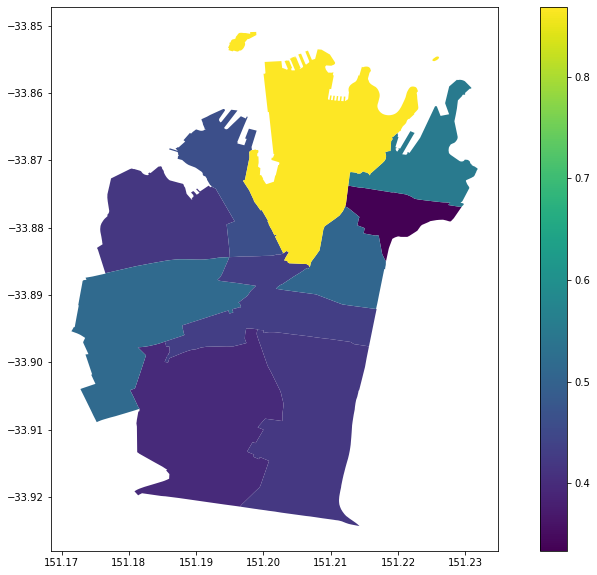

In [185]:
task3_score_vis = gpd.read_postgis(
"""
SELECT SH.SA2_MAIN16, ST_Transform(SH.geom, 4326) as "geom"
FROM sa2_shape SH
WHERE SH.sa3_name16 = 'Sydney Inner City'
ORDER BY SH.SA2_MAIN16 
"""
, conn)
task3_score_vis['score'] = z_scores['task_3_score']
task3_score_vis.plot(column='score', legend=True, figsize=(15, 10))

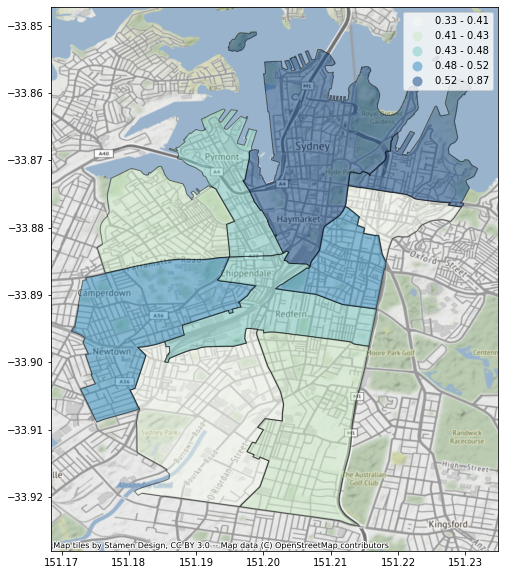

In [186]:
task3_score_vis = task3_score_vis.to_crs(epsg=4326)
ax = task3_score_vis.plot(column='score',figsize=(10, 10), alpha=0.5, edgecolor='k' ,cmap='GnBu',legend=True,scheme="quantiles")#Add background tiles to plot
ctx.add_basemap(ax, crs=task3_score_vis.crs.to_string())

### Recommendation

It is recommended that the stakeholder seeks accomodation in the one of the following areas:

1. Sydney/ Haymarket/ The Rocks
2. Potts Point/ Woolloomooloo
3. Newtown/ Camperdown/ Darlington

This is because the liveability scores of these areas are higher and alligned with what he's looking for.

# END

In [187]:
conn.close()
db.dispose()